In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import json

import warnings
warnings.filterwarnings('ignore')

(128, 401)

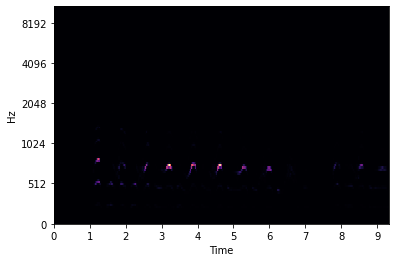

In [2]:
file_name = 'F01/Session1/wav_arrayMic/0001.wav'
y, sr = librosa.load(file_name)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(ps, y_axis='mel', x_axis='time')
ps.shape

(128, 401)

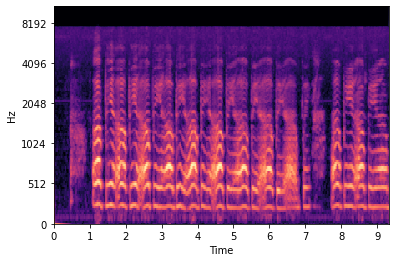

In [3]:
ts = librosa.power_to_db(ps, ref=np.max)
librosa.display.specshow(ts, y_axis='mel', x_axis='time')
ts.shape

(128, 495)

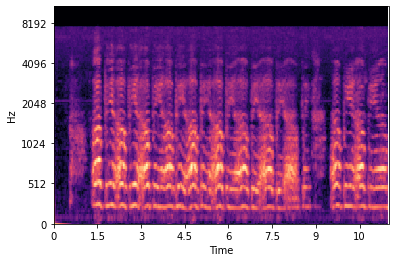

In [4]:
y_changed = librosa.effects.time_stretch(y, rate=0.81)
ps = librosa.feature.melspectrogram(y=y_changed, sr=sr)
ps = librosa.power_to_db(ps, ref=np.max)
librosa.display.specshow(ps, y_axis='mel', x_axis='time')
ps.shape

In [5]:
import numpy as np

arr = np.random.randint(0, 10, (7, 4))

def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [6]:
import os
import numpy as np
from tqdm import tqdm

D = []
data = {
        "spect": [],
        "label": []
       }

directories =[  
                 ['F01','Atypical'],['F03','Atypical'],['F04','Atypical'],['FC01','Typical'],['FC02','Typical'],
                 ['FC03','Typical'],['M01','Atypical'],['M02','Atypical'],['M03','Atypical'],['M04','Atypical'],
                 ['M05','Atypical'],['MC01','Typical'],['MC02','Typical'],['MC03','Typical'],['MC04','Typical']
             ]

for pair in directories:
    directory = pair[0]
    label = pair[1]
    print(directory)
    for filename in os.listdir(directory):
        if filename != 'Notes':
            file = os.path.join(directory, filename)
            file = os.path.join(file, 'wav_arrayMic')
            if os.path.isdir(file):
                for audiofile in tqdm(os.listdir(file)):
                    f = os.path.join(file, audiofile)
                    if os.path.isfile(f):
                        if librosa.get_duration(filename=f) != 0:
                            y, sr = librosa.load(f)
                            
                            y_changed = librosa.effects.time_stretch(y, rate=0.81)
                            ps = librosa.feature.melspectrogram(y=y_changed, sr=sr)
                            ps = librosa.power_to_db(ps, ref=np.max)
                            if ps.shape[1] > 400 : continue
                            PS = ps
                            data["spect"].append(PS.tolist())
                            data["label"].append(label)
                            D.append( (np.array(padding(ps,128,400)), label) )

F01


100%|██████████| 134/134 [00:14<00:00,  8.96it/s]


F03


100%|██████████| 209/209 [00:23<00:00,  8.85it/s]


F04


100%|██████████| 249/249 [00:37<00:00,  6.61it/s]


FC01


100%|██████████| 256/256 [00:37<00:00,  6.82it/s]


FC02


100%|██████████| 992/992 [02:03<00:00,  8.02it/s]


FC03


100%|██████████| 208/208 [00:20<00:00, 10.05it/s]


M01


100%|██████████| 286/286 [00:43<00:00,  6.51it/s]


M02


100%|██████████| 160/160 [00:30<00:00,  5.24it/s]


M03


100%|██████████| 416/416 [01:07<00:00,  6.15it/s]


M04


100%|██████████| 295/295 [00:52<00:00,  5.58it/s]


M05


100%|██████████| 128/128 [00:25<00:00,  5.08it/s]


MC01


100%|██████████| 419/419 [01:03<00:00,  6.63it/s]


MC02


100%|██████████| 307/307 [00:57<00:00,  5.38it/s]


MC03


100%|██████████| 300/300 [00:32<00:00,  9.27it/s]


MC04


100%|██████████| 373/373 [00:40<00:00,  9.26it/s]


In [7]:
print("Number of samples: ", len(D))

Number of samples:  9091


In [8]:
dataset = D
random.shuffle(dataset)

train = dataset[:8000]
dataset = dataset[8000:]
validate = dataset[:1000]
test = dataset[1000:]

X_train, y_train = zip(*train)
X_validate, y_validate = zip(*validate)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 400, 1) ) for x in X_train])
X_validate = np.array([x.reshape( (128, 400, 1) ) for x in X_validate])
X_test = np.array([x.reshape( (128, 400, 1) ) for x in X_test])

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
#y=to_categorical(labelencoder.fit_transform(y))
#y
y_train = np.array(to_categorical(labelencoder.fit_transform(y_train)))
y_validate = np.array(to_categorical(labelencoder.fit_transform(y_validate)))
y_test = np.array(to_categorical(labelencoder.fit_transform(y_test)))

In [10]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((8000, 128, 400, 1),
 (1000, 128, 400, 1),
 (91, 128, 400, 1),
 (8000, 2),
 (1000, 2),
 (91, 2))

In [11]:
with open('CNN_DB-mel_RateBoosted_0.81.json', "w") as fp:json.dump(data, fp, indent=1)

In [12]:
import gc

del D
del dataset
del train
del validate
del test
del data
gc.collect()

77

In [13]:
model = Sequential()
input_shape=(128, 400, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 396, 24)      624       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 198, 24)      0         
 )                                                               
                                                                 
 activation (Activation)     (None, 31, 198, 24)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 194, 48)       28848     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 97, 48)        0         
 2D)                                                             
                                                                 
 activation_1 (Activation)   (None, 6, 97, 48)         0

In [14]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train,epochs=25,batch_size=128,validation_data= (X_validate, y_validate))
score = model.evaluate(x=X_test,y=y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25
63/63 [==============================] - 154s 2s/step - loss: 0.9700 - accuracy: 0.6488 - val_loss: 0.6289 - val_accuracy: 0.6770
Epoch 2/25
63/63 [==============================] - 154s 2s/step - loss: 0.6286 - accuracy: 0.6801 - val_loss: 0.6244 - val_accuracy: 0.6770
Epoch 3/25
63/63 [==============================] - 155s 2s/step - loss: 0.6215 - accuracy: 0.6826 - val_loss: 0.6030 - val_accuracy: 0.6770
Epoch 4/25
63/63 [==============================] - 155s 2s/step - loss: 0.6031 - accuracy: 0.6925 - val_loss: 0.6172 - val_accuracy: 0.6770
Epoch 5/25
63/63 [==============================] - 154s 2s/step - loss: 0.6023 - accuracy: 0.6902 - val_loss: 0.5662 - val_accuracy: 0.6940
Epoch 6/25
63/63 [==============================] - 156s 2s/step - loss: 0.5593 - accuracy: 0.7370 - val_loss: 0.5094 - val_accuracy: 0.7730
Epoch 7/25
63/63 [==============================] - 155s 2s/step - loss: 0.4902 - accuracy: 0.7822 - val_loss: 0.3806 - val_accuracy: 0.8170
Epoch 8/25
63

In [15]:
model.save('CNN_DB-mel_RateBoosted_0.81_model')

INFO:tensorflow:Assets written to: CNN_DB-mel_RateBoosted_0.81_model\assets


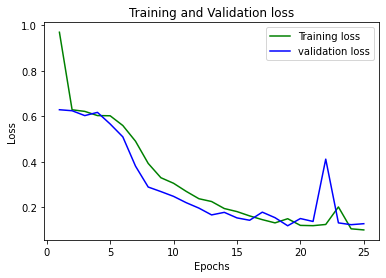

In [16]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,26)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

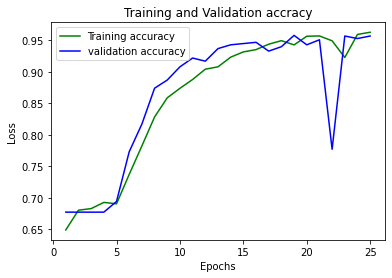

In [17]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,26)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
reconstructed_model = keras.models.load_model("CNN_DB-mel_PitchBoosted_-2.5_model")